In [1]:
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

In [2]:
# Reading the dataset
data_csv = "dataset.csv"
df = pd.read_csv(data_csv)
print('Dataset shape: ', df.shape)
print(df.dtypes)
df.head()

Dataset shape:  (1089, 7)
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-31,1196.400024,1212.400024,1182.000000,1201.900024,1201.900024,124.0
1,2014-01-02,1204.300049,1227.300049,1204.300049,1225.000000,1225.000000,209.0
2,2014-01-03,1221.699951,1239.000000,1221.699951,1238.400024,1238.400024,142.0
3,2014-01-06,1232.800049,1247.000000,1221.900024,1237.800049,1237.800049,127.0
4,2014-01-07,1239.300049,1242.400024,1226.300049,1229.400024,1229.400024,73.0


In [3]:
# Verifying null values and deleting name from dataset
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())
# Drop the lines with null values
df = df.dropna()
# Drop Date column
# df.pop("Date")

print('Dataset shape: ', df.shape)

     Open  High  Low  Close  Adj Close  Volume
127   NaN   NaN  NaN    NaN        NaN     NaN
230   NaN   NaN  NaN    NaN        NaN     NaN
248   NaN   NaN  NaN    NaN        NaN     NaN
515   NaN   NaN  NaN    NaN        NaN     NaN
535   NaN   NaN  NaN    NaN        NaN     NaN
Dataset shape:  (1081, 7)


In [4]:
print("Minimum: {}\nMaximum: {}\nMean: {}\nMedian: {}\nSD: {}\nSkewness: {}\nKurtosis: {}".format(df["Low"].min(), df["High"].max(), 
df["Open"].mean(), df["Open"].median(), df["Open"].std(), df["Open"].skew(), df["Open"].kurtosis()))

Minimum: 1046.199951
Maximum: 1391.400024
Mean: 1239.990934614246
Median: 1251.0
SD: 72.09937994027128
Skewness: -0.5455305158449637
Kurtosis: -0.3520037164214358


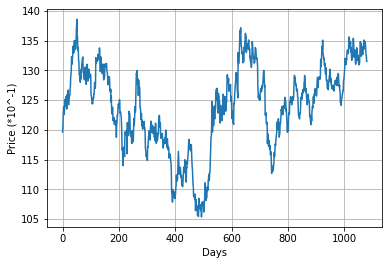

In [5]:
lastday_2017 = df.loc[df["Date"]=="2017-12-29"].index.values[0]
df = df["Open"].values


plt.figure()
plt.plot(df/10)
plt.xlabel("Days")
plt.ylabel("Price (*10^-1)")
plt.grid()
plt.show()

In [6]:
# Transforming the dataset to ln scale
df = np.log(df)

# # Split dataset into train and test
train_set = df[0:lastday_2017]
test_set = df[lastday_2017:]
print("Train: ", train_set.shape, "Test: ", test_set.shape)
lastday_2017

Train:  (1007,) Test:  (74,)


1007

## Labels of an LSTM network
Now for the labels of the LSTM network, not all the cases require a label matrix of 3 dimensions. The cases where this is required are on sequence to sequence problems, where the model is made to predict a sequence of timestamps of one or more features. However for our problem, the LSTM network needs to predict the next day gold price closing value, this way a matrix of 2 dimensions will suffice for this problem.

# Regression models

In [7]:
# FFNN class
class FFNN:
    def __init__(self, input_dim, scaler=None):
        self.scaler = scaler 
        optimizer = Adam()
        h_n = 3 if input_dim == 4 or input_dim == 6 else 5
        self.model = Sequential()
        self.model.add(Dense(h_n, input_dim=input_dim))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy", "mean_absolute_error"])
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)
        self.model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=128,
                        verbose=0
                      )

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [8]:
# LSTM class
class PLSTM:
    def __init__(self, input_shape, model_type, scaler=None):
        self.scaler = scaler 
        optimizer = Adam()
        self.model = Sequential()
        self.h_n1 = 100 if model_type in [1,3,4] else 200
        return_seq = True if model_type>2 else False
        self.model.add(LSTM(units=self.h_n1, input_shape=(input_shape[1], 1), return_sequences=return_seq))
        if model_type>2:
            self.h_n2 = 50 if model_type == 3 else 100
            self.model.add(LSTM(units=self.h_n2))
            if type==4:
                self.model.add(Dense(32))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy", "mean_absolute_error"])
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)

        # reshape the entry as a 3D matrix with samples, timestamps and lastly features
        # instead of only samples and features as usual.
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        history = self.model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=128,
                        verbose=0)

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [9]:
# CNN-LSTM class
class CNNLSTM:
    def __init__(self, input_shape, model_type, scaler=None):
        self.scaler = scaler
        optimizer = Adam()
        self.model = Sequential()
        self.h_n1 = 100 if model_type == 1 else 200
        self.filter1 = 32 if model_type == 1 else 64
        self.filter2 = 64 if model_type == 1 else 128
        
        self.model.add(Conv1D(self.filter1, 2,activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=(input_shape[1],
                                   1)))

        self.model.add(Conv1D(self.filter2, 2,
                   activation='relu',
                   strides=1,
                   padding='same',
                   input_shape=(input_shape[1],
                                1)))

        self.model.add(MaxPooling1D(pool_size=2, padding='valid'))
        self.model.add(LSTM(units=self.h_n1, input_shape=(input_shape[1],1)))
    
        if type==2:
            self.model.add(Dense(32))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer)
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)
            
        # reshape the entry as a 3D matrix with samples, timestamps and lastly features
        # instead of only samples and features as usual.
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        
        self.model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=128,
                        verbose=0
                      )

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [10]:
def create_models(entry_shape, scaler=None):
    # SVR
    svr = SVR(kernel='rbf', C=1, tol=1e-3)

    # FFNN
    ffnn = FFNN(entry_shape[1], scaler)

    # LSTM1
    lstm1 = PLSTM(entry_shape, 1, scaler)

    # LSTM2
    lstm2 = PLSTM(entry_shape, 2, scaler)

    # LSTM3
    lstm3 = PLSTM(entry_shape, 3, scaler)

    # LSTM4
    lstm4 = PLSTM(entry_shape, 4, scaler)

    # CNN-LSTM1
    cnnlstm1 = CNNLSTM(entry_shape, 1, scaler)

    # CNN-LSTM2
    cnnlstm2 = CNNLSTM(entry_shape, 2, scaler)

    labels = ["SVR", "FFNN", "LSTM1", "LSTM2", "LSTM3", "LSTM4", "CNN-LSTM1", "CNN-LSTM2"]
    models = [svr, ffnn, lstm1, lstm2, lstm3, lstm4, cnnlstm1, cnnlstm2]

    return labels, models

## Rolling window approach
The paper states that in order to predict the next day gold price, the model uses the $n$ past days gold prince, where $n$ stands for the time horizon used. Thus to generate a dataset with this specifications, we will use a rolling window algorithm to generate a window of features to a window of labels ( with in this case is equal to 1). This rolling window procedure works as follows:

Features: $[n1, n2, n3, n4, n5]$ -> Label $[n6]$

In [11]:
def rolling_window_mtx(x, window_size):
        """Compute all overlapping (rolling) observation windows over a vector 
            and return a matrix

        Args:
            x           : observation vector that is supposed to be split into
                          overlapping windows
            window_size : the target window size

        Returns:

            Window matrix with all windows as rows. That is, if n_windows is the
            number of windows, the result has dimensions:

            (n_windows, window_size)

        """
        if window_size < 1:
            raise ValueError("`window_size` must be at least 1.")
        if window_size > x.shape[-1]:
            raise ValueError("`window_size` is too long.")

        shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
        strides = x.strides + (x.strides[-1],)

        return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [12]:
def generate_feat_labels_per_horizon(time_horizon, df, verbose=False):

    # Get the feature and label to the prediction task 
    feature_mtx = rolling_window_mtx(df, time_horizon)[:-1]
    label_mtx   = rolling_window_mtx(df[time_horizon:], 1)
    index_mtx   = rolling_window_mtx(np.arange(len(df)), time_horizon)

    if verbose:
        # Now we have a set of windows of the real coordinate
        # Lets take a look in one window
        print(f"\n One feature window: \n {feature_mtx[0]}")
        print(f"\n One label window: \n {label_mtx[0]}")
        print(f"\n Original dataset: \n {df[0:5]}")

    # For the classification task (if the gold values goes up or down)
    # We need to get a window of size 2, and then calculate the difference
    # If positive, the gold value went up.
    class_label_mtx = rolling_window_mtx(df[time_horizon-1:], 2)
    func = lambda x: True if x > 0 else False
    class_func = np.vectorize(func)
    class_label_mtx = class_func(np.diff(class_label_mtx).flatten()).reshape(len(class_label_mtx),1)
   
    if verbose:
    
        print(f"\n One window of class label (If tomorrow price is larger than today's price): \n {class_label_mtx[0]}")
    
    return feature_mtx, label_mtx, class_label_mtx

In [13]:
label_index_mtx = rolling_window_mtx(np.arange(len(df))[4:], 1)
index_mtx   = rolling_window_mtx(np.arange(len(df)), 4)[:-1]

In [14]:
train_idx = lastday_2017 - 4
index_mtx[train_idx], label_index_mtx[train_idx]

(array([1003, 1004, 1005, 1006]), array([1007]))

## Normalizing dataset

In [15]:
df = df.reshape(len(df),1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df = df.flatten()
df

array([7.08707235, 7.0936538 , 7.10799857, ..., 7.18841274, 7.18212409,
       7.18182009])

In [16]:
entries = [4, 6, 9]
models = []
labels = []
for entry in entries:
    #Creating dataset
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(entry, df)
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(feature_mtx)
    scaler_output = MinMaxScaler(feature_range=(-1, 1))
    scaler_output.fit(label_mtx)
    train_idx = lastday_2017 - entry
    train_x = feature_mtx[:train_idx]
    train_y = label_mtx[:train_idx]
    tmp_labels, tmp_models = create_models(train_x.shape)#, scaler)
    for i in range(len(tmp_models)):
        print(tmp_labels[i])
        tmp_models[i].fit(train_x, train_y)
    models.append(tmp_models)
    labels.append(tmp_labels)

SVR
FFNN
/home/cleversonahum/.local/share/virtualenvs/CNN-LSTM_gold_price-o7kuqWqa/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
LSTM1
LSTM2
LSTM3
LSTM4
CNN-LSTM1
CNN-LSTM2
SVR
FFNN
/home/cleversonahum/.local/share/virtualenvs/CNN-LSTM_gold_price-o7kuqWqa/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
LSTM1
LSTM2
LSTM3
LSTM4
CNN-LSTM1
CNN-LSTM2
SVR
FFNN
/home/cleversonahum/.local/share/virtualenvs/CNN-LSTM_gold_price-o7kuqWqa/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

In [17]:
models = np.ravel(models)
labels = np.ravel(labels)
print(len(models))

24


In [18]:
def classification_pred(y):
    preds = []
    for i in range(1, len(y)):
        last_y = y[i - 1]
        curr_y = y[i]
        preds.append(curr_y - last_y > 0.0 )
    return np.array(preds)

# Metric functions
def get_metrics(y, pred_y):
    y_classification = classification_pred(y)
    y_pred_classification = classification_pred(pred_y)
    
    fpr, tpr, thresholds = roc_curve(y_classification, y_pred_classification)
    auc_value = auc(fpr, tpr)

    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(len(y_classification)):
        is_y_pred_up = y_pred_classification[i]
        is_y_up = y_classification[i][0]

        if is_y_pred_up and is_y_up:
            tp += 1
        elif is_y_pred_up and not is_y_up:
            fp += 1
        elif not is_y_pred_up and not is_y_up:
            tn += 1
        else:
            fn += 1

    return tp, tn, fp, fn, auc_value

In [20]:
# Testing models
index_model = 0
for entry in entries:
    print ("# Entries: ", entry)
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(entry, df)
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(feature_mtx)
    train_idx = lastday_2017 - entry
    test_x = feature_mtx[train_idx:]
    test_y = label_mtx[train_idx:]
    
    model_list = []
    MAE_list = []
    RMSE_list = []
    ACC_list = []
    AUC_list = []
    SEN_list = []
    SPE_list = []
    
    for i in range(index_model, index_model+8):
        test_y_estimative = models[i].predict(test_x)
        tp, tn, fp, fn, auc_value = get_metrics(test_y, test_y_estimative)
        
        print("\nClassifier type: ", labels[i])
        print("MAE = ", mean_absolute_error(test_y, test_y_estimative))
        print("RMSE = ", mean_squared_error(test_y, test_y_estimative, squared=True))
        print("ACC = ", (tp + tn) / (tp + tn + fp + fn))
        print("AUC = ", auc_value)
        print("SEN = ", tp / (tp + fn))
        print("SPE = ", tn / (tn + fp))
        print("TP = ", tp)
        print("TN = ", tn)
        print("FP = ", fp)
        print("FN = ", fn)
        
        model_list.append(labels[i])
        MAE_list.append(mean_absolute_error(test_y, test_y_estimative))
        RMSE_list.append(mean_squared_error(test_y, test_y_estimative, squared=True))
        ACC_list.append(((tp + tn) / (tp + tn + fp + fn))*100)
        AUC_list.append(auc_value)
        SEN_list.append(tp / (tp + fn))
        SPE_list.append(tn / (tn + fp))
        
    df_print = pd.DataFrame(list(zip(model_list, MAE_list,RMSE_list,ACC_list,AUC_list,SEN_list, SPE_list)),
           columns =['Model', 'MAE', 'RMSE', 'ACC (%)', 'AUC', 'SPEN', 'SPE'])
    df_print.style
    display(df_print)
        
    index_model += 8

# Entries:  4

Classifier type:  SVR
MAE =  0.06545422381314349
RMSE =  0.004345634031822117
ACC =  0.4383561643835616
AUC =  0.4347662141779789
SEN =  0.48717948717948717
SPE =  0.38235294117647056
TP =  19
TN =  13
FP =  21
FN =  20

Classifier type:  FFNN
MAE =  0.006243084452771838
RMSE =  6.016190667923057e-05
ACC =  0.5205479452054794
AUC =  0.5211161387631976
SEN =  0.5128205128205128
SPE =  0.5294117647058824
TP =  20
TN =  18
FP =  16
FN =  19

Classifier type:  LSTM1
MAE =  0.0657593443286445
RMSE =  0.004406134358293345
ACC =  0.3835616438356164
AUC =  0.3815987933634992
SEN =  0.41025641025641024
SPE =  0.35294117647058826
TP =  16
TN =  12
FP =  22
FN =  23

Classifier type:  LSTM2
MAE =  0.05362736338109844
RMSE =  0.002952316078224583
ACC =  0.3698630136986301
AUC =  0.3687782805429864
SEN =  0.38461538461538464
SPE =  0.35294117647058826
TP =  15
TN =  12
FP =  22
FN =  24

Classifier type:  LSTM3
MAE =  0.07591989359556278
RMSE =  0.005847012449624273
ACC =  0.38356164

,Model,MAE,RMSE,ACC (%),AUC,SPEN,SPE
0,SVR,0.065454,0.004346,43.835616,0.434766,0.487179,0.382353
1,FFNN,0.006243,0.000060,52.054795,0.521116,0.512821,0.529412
2,LSTM1,0.065759,0.004406,38.356164,0.381599,0.410256,0.352941
3,LSTM2,0.053627,0.002952,36.986301,0.368778,0.384615,0.352941
4,LSTM3,0.075920,0.005847,38.356164,0.377828,0.461538,0.294118
5,LSTM4,0.068632,0.004791,43.835616,0.434766,0.487179,0.382353
6,CNN-LSTM1,0.057837,0.003410,42.465753,0.423831,0.435897,0.411765
7,CNN-LSTM2,0.059081,0.003556,42.465753,0.427602,0.384615,0.470588


# Entries:  6

Classifier type:  SVR
MAE =  0.06427217056847337
RMSE =  0.004197745836843683
ACC =  0.4657534246575342
AUC =  0.46040723981900444
SEN =  0.5384615384615384
SPE =  0.38235294117647056
TP =  21
TN =  13
FP =  21
FN =  18

Classifier type:  FFNN
MAE =  0.07698913648537949
RMSE =  0.006036784666449123
ACC =  0.589041095890411
AUC =  0.5889894419306184
SEN =  0.5897435897435898
SPE =  0.5882352941176471
TP =  23
TN =  20
FP =  14
FN =  16

Classifier type:  LSTM1
MAE =  0.07649800709992102
RMSE =  0.005935289881258486
ACC =  0.5068493150684932
AUC =  0.504524886877828
SEN =  0.5384615384615384
SPE =  0.47058823529411764
TP =  21
TN =  16
FP =  18
FN =  18

Classifier type:  LSTM2
MAE =  0.06857862469528433
RMSE =  0.004782654004264152
ACC =  0.5342465753424658
AUC =  0.5282805429864253
SEN =  0.6153846153846154
SPE =  0.4411764705882353
TP =  24
TN =  15
FP =  19
FN =  15

Classifier type:  LSTM3
MAE =  0.07673084539552254
RMSE =  0.0059711673359546195
ACC =  0.5479452054794

,Model,MAE,RMSE,ACC (%),AUC,SPEN,SPE
0,SVR,0.064272,0.004198,46.575342,0.460407,0.538462,0.382353
1,FFNN,0.076989,0.006037,58.904110,0.588989,0.589744,0.588235
2,LSTM1,0.076498,0.005935,50.684932,0.504525,0.538462,0.470588
3,LSTM2,0.068579,0.004783,53.424658,0.528281,0.615385,0.441176
4,LSTM3,0.076731,0.005971,54.794521,0.544872,0.589744,0.500000
5,LSTM4,0.074410,0.005620,50.684932,0.502640,0.564103,0.441176
6,CNN-LSTM1,0.067158,0.004583,47.945205,0.480769,0.461538,0.500000
7,CNN-LSTM2,0.065297,0.004333,41.095890,0.412896,0.384615,0.441176


# Entries:  9

Classifier type:  SVR
MAE =  0.06351511560001902
RMSE =  0.0041044610473757485
ACC =  0.4383561643835616
AUC =  0.4366515837104073
SEN =  0.46153846153846156
SPE =  0.4117647058823529
TP =  18
TN =  14
FP =  20
FN =  21

Classifier type:  FFNN
MAE =  0.015749497353261484
RMSE =  0.0003634571174030538
ACC =  0.4931506849315068
AUC =  0.4898190045248868
SEN =  0.5384615384615384
SPE =  0.4411764705882353
TP =  21
TN =  15
FP =  19
FN =  18

Classifier type:  LSTM1
MAE =  0.07683830129349815
RMSE =  0.005986317870944667
ACC =  0.4657534246575342
AUC =  0.46417797888386125
SEN =  0.48717948717948717
SPE =  0.4411764705882353
TP =  19
TN =  15
FP =  19
FN =  20

Classifier type:  LSTM2
MAE =  0.07214191923486481
RMSE =  0.00528837330207905
ACC =  0.3150684931506849
AUC =  0.3080693815987934
SEN =  0.41025641025641024
SPE =  0.20588235294117646
TP =  16
TN =  7
FP =  27
FN =  23

Classifier type:  LSTM3
MAE =  0.07826115115484937
RMSE =  0.0062084529518559705
ACC =  0.32876712

,Model,MAE,RMSE,ACC (%),AUC,SPEN,SPE
0,SVR,0.063515,0.004104,43.835616,0.436652,0.461538,0.411765
1,FFNN,0.015749,0.000363,49.315068,0.489819,0.538462,0.441176
2,LSTM1,0.076838,0.005986,46.575342,0.464178,0.487179,0.441176
3,LSTM2,0.072142,0.005288,31.506849,0.308069,0.410256,0.205882
4,LSTM3,0.078261,0.006208,32.876712,0.322775,0.410256,0.235294
5,LSTM4,0.080770,0.006608,39.726027,0.401961,0.333333,0.470588
6,CNN-LSTM1,0.067901,0.004685,46.575342,0.464178,0.487179,0.441176
7,CNN-LSTM2,0.063838,0.004150,45.205479,0.449472,0.487179,0.411765
